# Imports

In [3]:
import pandas as pd
import random
import pickle
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.8 MB/s eta 0:00:00


# Function

In [4]:
def plot_results(history, epochs):
  acc = history.history['Accuracy']
  val_acc = history.history['val_Accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_intervals = range(epochs)
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_intervals, acc, label='Train Accuracy')
  plt.plot(epochs_intervals, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_intervals, loss, label='Train Loss')
  plt.plot(epochs_intervals, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.show()

In [5]:
def build_model(hp):
    model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=hp.Int('embedding_dim', min_value=32, max_value=128, step=32),
            mask_zero=True
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
            units=hp.Int('lstm_units', min_value=32, max_value=128, step=32),
            return_sequences=True
        )),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
            units=hp.Int('lstm_units', min_value=16, max_value=64, step=16)
        )),
        tf.keras.layers.Dense(
            units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
            activation='relu'
        ),
        tf.keras.layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# Função para fazer a validação cruzada e otimização de hiperparâmetros
def run_tuner(X, y, n_splits=5):
   kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

   for train_index, val_index in kf.split(X):
       X_train_fold, X_val_fold = X[train_index], X[val_index]
       y_train_fold, y_val_fold = y[train_index], y[val_index]

       tuner.search(X_train_fold, y_train_fold, epochs=10, validation_data=(X_val_fold, y_val_fold))

   # Resumo dos melhores hiperparâmetros encontrados
   best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
   print(f"""
         A pesquisa de hiperparâmetros foi concluída. O número ideal de dimensões de incorporação é {best_hps.get('embedding_dim')},
         o número ideal de unidades LSTM é {best_hps.get('lstm_units')}, e
         o número ideal de unidades densas é {best_hps.get('dense_units')},
         e a taxa de abandono ideal é {best_hps.get('dropout')}.
   """)

   return best_hps

In [7]:
def prepare_sequences(sequences):
    """
    Prepara as sequências para o modelo, removendo zeros à direita, adicionando padding à esquerda, truncado sequências longas e removendo sequências repetidas.

    Args:
        sequences: Um array de sequências (listas ou arrays NumPy).

    Returns:
        Um array NumPy 2D com as sequências preparadas.
    """

    # Remover zeros à direita de cada sequência
    sequences_without_trailing_zeros = []
    for seq in sequences:
        last_nonzero_index = np.argmax(seq[::-1] != 0)
        if last_nonzero_index == 0 and seq[-1] == 0:
            sequences_without_trailing_zeros.append(np.array([0]))
        else:
            sequences_without_trailing_zeros.append(seq[:-last_nonzero_index or None])

    # Remover sequências repetidas
    unique_sequences = []
    for seq in sequences_without_trailing_zeros:
        if seq.tolist() not in unique_sequences:  # Verifica se a sequência já está na lista
            unique_sequences.append(seq.tolist())  # Adiciona à lista se for única

    # Encontrar o comprimento máximo das sequências sem zeros à direita
    max_sequence_len = max(len(seq) for seq in unique_sequences)

    # Adicionar padding à esquerda para garantir o mesmo comprimento
    padded_sequences = pad_sequences(unique_sequences, maxlen=max_sequence_len, padding='pre', truncating='post')

    return padded_sequences

# Data

In [8]:
df = pd.read_csv('https://github.com/allanspadini/curso-tensorflow-proxima-palavra/raw/main/dados/train.zip',
                 names=['ClassIndex', 'Título', 'Descrição'], header=None)

In [ ]:
df.head()

,ClassIndex,Título,Descrição
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


# Preprocessing

## Features

In [9]:
df['text'] = df['Título'] + df['Descrição']

In [ ]:
df.head()

,ClassIndex,Título,Descrição,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."


In [10]:
df['ClassIndex'] -= 1

In [ ]:
df['ClassIndex'].unique()

array([2, 3, 1, 0])

## Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'].values, df['ClassIndex'].values, random_state=7, test_size=0.2)

## Encoder

In [ ]:
VOCAB_SIZE = 1_000

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

In [ ]:
encoder.adapt(X_train)

In [ ]:
encoder.get_vocabulary()[:5]

['', '[UNK]', np.str_('the'), np.str_('to'), np.str_('a')]

In [ ]:
encoder('This is an example')

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([41, 16, 24,  1])>

# Model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=16,
        mask_zero=True
    ),
    tf.keras.layers.GlobalAveragePooling1D(), # Dimensionality reduction
    tf.keras.layers.Dense(16, activation='relu'), # Hidden layer
    tf.keras.layers.Dense(4, activation='softmax') # Output
])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (1, None)              │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (1, None, 16)          │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (1, 16)                │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 16)                │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (1, 4)                 │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,340 (63.83 KB)

 Trainable params: 16,340 (63.83 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['Accuracy']
)

In [ ]:
epochs = 10

In [ ]:
history = model.fit(x=X_train, y=y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - Accuracy: 0.4949 - loss: 1.3265 - val_Accuracy: 0.7563 - val_loss: 0.9604
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - Accuracy: 0.7752 - loss: 0.8440 - val_Accuracy: 0.8061 - val_loss: 0.6274
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - Accuracy: 0.8136 - loss: 0.5900 - val_Accuracy: 0.8240 - val_loss: 0.5290
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - Accuracy: 0.8261 - loss: 0.5177 - val_Accuracy: 0.8320 - val_loss: 0.4905
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - Accuracy: 0.8395 - loss: 0.4773 - val_Accuracy: 0.8382 - val_loss: 0.4700
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - Accuracy: 0.8446 - loss: 0.4600 - val_Accuracy: 0.8422 - val_loss: 0.4577
Epoch 7/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - Accuracy: 0.8473 - loss: 0.4492 - val_Accuracy: 0.8461 - val_loss: 0.4492
Epoch 8/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - Accuracy: 0.8504 - loss: 0

In [ ]:
model.predict(X_test[0:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


array([[2.41511315e-03, 9.97438312e-01, 2.98898049e-05, 1.16686875e-04]],
      dtype=float32)

In [ ]:
model.predict(X_test[0:1]).argmax(axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


array([1])

In [ ]:
y_test[0]

np.int64(1)

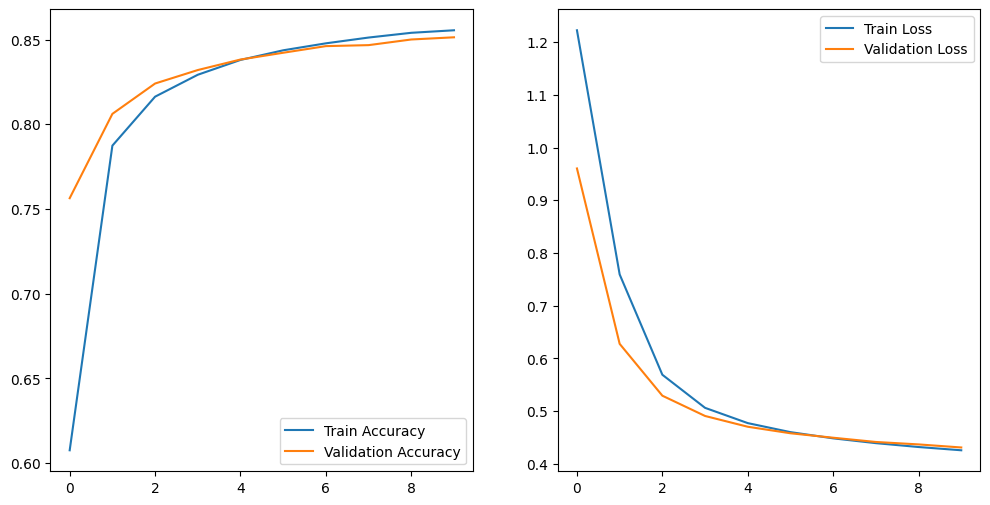

In [ ]:
plot_results(history, epochs)

## CONV Layer

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=16,
        mask_zero=False
    ),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(128, kernel_size=4, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(), # Dimensionality reduction
    tf.keras.layers.Dense(16, activation='relu'), # Hidden layer
    tf.keras.layers.Dense(4, activation='softmax') # Output
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['Accuracy']
)

In [ ]:
history = model.fit(x=X_train, y=y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - Accuracy: 0.5115 - loss: 1.1055 - val_Accuracy: 0.8138 - val_loss: 0.5268
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - Accuracy: 0.8239 - loss: 0.5059 - val_Accuracy: 0.8304 - val_loss: 0.4875
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - Accuracy: 0.8375 - loss: 0.4674 - val_Accuracy: 0.8354 - val_loss: 0.4743
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - Accuracy: 0.8416 - loss: 0.4522 - val_Accuracy: 0.8418 - val_loss: 0.4572
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - Accuracy: 0.8460 - loss: 0.4411 - val_Accuracy: 0.8455 - val_loss: 0.4440
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - Accuracy: 0.8491 - loss: 0.4301 - val_Accuracy: 0.8479 - val_loss: 0.4340
Epoch 7/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - Accuracy: 0.8542 - loss: 0.4152 - val_Accuracy: 0.8539 - val_loss: 0.4190
Epoch 8/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - Accuracy: 0.8574 - loss: 0

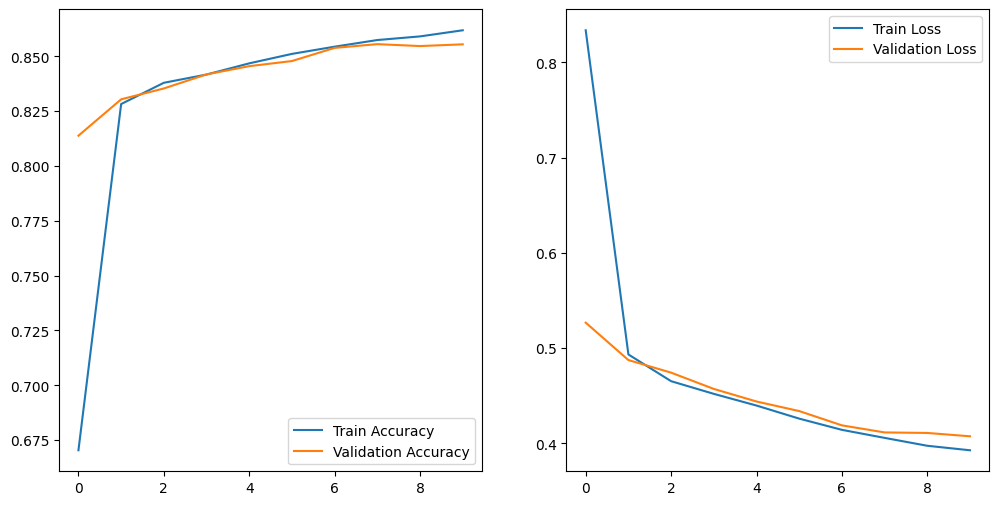

In [ ]:
plot_results(history, epochs)

## LSTM

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(16, activation='relu'), # Hidden layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax') # Output
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['Accuracy']
)

In [ ]:
epochs = 20

history = model.fit(x=X_train, y=y_train, epochs=epochs, validation_data=(X_test, y_test))

In [ ]:
plot_results(history, epochs)

## Hyperparameter

In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='classification_optimization'
)

In [ ]:
final_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=96,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        units=64,
        return_sequences=True
    )),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        units=32
    )),
    tf.keras.layers.Dense(
        units=96,
        activation='relu'
    ),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [ ]:
# Compilar o modelo final
final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
final_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10


2025-03-01 10:13:45.117661: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 237s 77ms/step - accuracy: 0.7737 - loss: 0.5865 - val_accuracy: 0.8451 - val_loss: 0.4324
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 351s 117ms/step - accuracy: 0.8581 - loss: 0.4005 - val_accuracy: 0.8649 - val_loss: 0.3776
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 322s 107ms/step - accuracy: 0.8725 - loss: 0.3577 - val_accuracy: 0.8655 - val_loss: 0.3695
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 142s 47ms/step - accuracy: 0.8793 - loss: 0.3336 - val_accuracy: 0.8686 - val_loss: 0.3689
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 173s 58ms/step - accuracy: 0.8884 - loss: 0.3060 - val_accuracy: 0.8709 - val_loss: 0.3669
Epoch 6/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 171s 57ms/step - accuracy: 0.8959 - loss: 0.2859 - val_accuracy: 0.8719 - val_loss: 0.3688
Epoch 7/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 172s 57ms/step - accuracy: 0.9037 - loss: 0.2611 - val_accuracy: 0.8710 - val_loss: 0.3674
Epoch 8/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 170s 57ms/step - accuracy: 0.9099 - 

In [ ]:
y_pred = final_model.predict(X_test).argmax(axis=1)

750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step


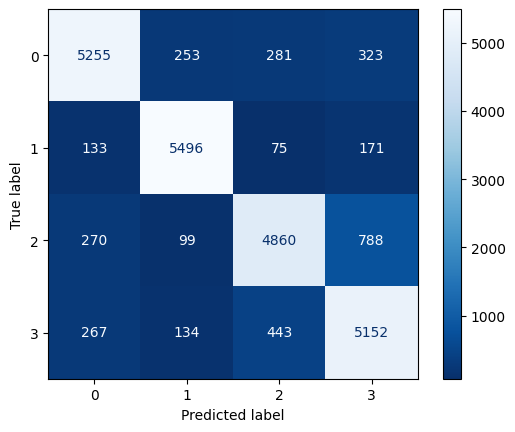

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=[0, 1, 2, 3])
disp.plot(cmap='Blues_r')
plt.show()

## Text Sugestion

### Vectorization

In [11]:
random.seed(7)
df_sample = df.sample(n=1_000)

In [12]:
corpus = df_sample['text'].to_list()

In [ ]:
corpus[:3]

['Intel Shows Wireless TransceiverPrototype 90-nanometer radio chip promises more power than current CMOS technology.',
 'Novak topples Henman to advance to semi-finalsJiri Novak made Tim Henman #39;s life as miserable yesterday as he did at this summer #39;s Olympics, toppling the second-seeded Briton 7-6 (5), 7-5 in the quarterfinals of the euro989,750 (US\\$1.',
 'Analyst Sees Cingular Awarding Deal Soon LOS ANGELES (Reuters) - Prudential Equity Group on Friday  said Cingular Wireless has made a decision on which vendors it  will use for the deployment of its next-generation wireless  network, with Ericsson &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=ERICb.ST target=/stocks/quickinfo/fullquote"&gt;ERICb.ST&lt;/A&gt; and Lucent Technologies Inc.  &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=LU.N target=/stocks/quickinfo/fullquote"&gt;LU.N&lt;/A&gt; likely the biggest beneficiaries.']

In [13]:
max_vocab_size = 20_000
max_sequence_length = 50

vectorizer = TextVectorization(max_tokens=max_vocab_size, output_sequence_length=max_sequence_length, output_mode='int')

In [14]:
vectorizer.adapt(corpus)

In [15]:
tokenized_corpus = vectorizer(corpus)

In [ ]:
# Vectorizer
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

In [16]:
# Sequence
input_sequences = []

for token_list in tokenized_corpus.numpy():
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [17]:
input_sequences[:3]

[array([1610,   94]),
 array([1610,   94,  497]),
 array([1610,   94,  497,   19])]

In [18]:
input_sequence_prepared = prepare_sequences(input_sequences)

In [ ]:
input_sequence_prepared[:3]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  504, 1769],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,  504, 1769,  255],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  5

### Model prep

In [19]:
X = input_sequence_prepared[:, :-1]
y = input_sequence_prepared[:, -1]

In [20]:
y = tf.keras.utils.to_categorical(y, num_classes=max_vocab_size)

In [ ]:
y[:3]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=max_vocab_size,
        output_dim=128,
        mask_zero=False
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'), # Hidden layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(max_vocab_size, activation='softmax') # Output
])

In [22]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['Accuracy']
)

In [23]:
model.fit(X, y, epochs=100, verbose=1, batch_size=64)

Epoch 1/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - Accuracy: 0.0324 - loss: 9.0992
Epoch 2/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - Accuracy: 0.0548 - loss: 7.4921
Epoch 3/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - Accuracy: 0.0673 - loss: 7.1775
Epoch 4/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - Accuracy: 0.0790 - loss: 6.9425
Epoch 5/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - Accuracy: 0.0893 - loss: 6.6869
Epoch 6/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - Accuracy: 0.1008 - loss: 6.4800
Epoch 7/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - Accuracy: 0.1130 - loss: 6.2138
Epoch 8/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - Accuracy: 0.1223 - loss: 6.0041
Epoch 9/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - Accuracy: 0.1422 - loss: 5.7074
Epoch 10/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - Accuracy: 0.1533 - loss: 5.5133
Epoch 11/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - Accuracy: 0.1689 - loss: 5.2941
Epoch 12/100
544/54

In [ ]:
model.